# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import statistics
from scipy import signal, stats, special
from scipy.optimize import curve_fit
import scipy.fftpack
from scipy import interpolate
from cycler import cycler
from inspect import signature

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

# Data structure

In [3]:
data_set = [{'Rl': 40, 'N': 64, 'folder_out' : 'correlations/', 'folder_in': 'norm_corr/', 'run_windows' : [1218], "file_type" : "two_point_corr_complex"},
        #{'Rl': 40, 'N': 64, 'folder_out' : 'filtered_advection/', 'folder_in': 'filter10/', 'run_windows' : [1008], "file_type" : "two_point_corr"},
        #{'Rl': 40, 'N': 128, 'folder_out' : 'correlations/', 'folder_in': 'norm_corr/', 'run_windows' : [77], "file_type" : "two_point_corr_complex"},
        #{'Rl': 60, 'N': 128, 'folder_out' : 'filtered_advection/','folder_in': 'filter12/', 'run_windows' : [664], "file_type" : "two_point_corr"}, 
        {'Rl': 60, 'N': 128, 'folder_out' : 'correlations/','folder_in': 'amp_corr/', 'run_windows' : [498], "file_type" : "two_point_corr_complex"}, 
        {'Rl': 90, 'N': 256, 'folder_out' : 'filtered_advection/','folder_in': 'large_window/', 'run_windows' : [102, 124, 129], "file_type" : "two_point_corr"},
        {'Rl': 160, 'N': 512, 'folder_out' : 'correlations/','folder_in': 'norm_corr/', 'run_windows' : [8, 8, 8, 7, 7, 8, 8, 8, 8, 8, 8, 8,8,8,8], "file_type" : "two_point_corr_complex"},
        #{'Rl': 160, 'N': 512, 'folder_out' : 'filtered_advection/','folder_in': 'large_window/', 'run_windows' : [9,11,11], "file_type" : "two_point_corr"},
        #{'Rl': 160, 'N': 512, 'folder_out' : 'filtered_advection/','folder_in': 'filter40/', 'run_windows' : [57, 57, 57, 29, 58, 58], "file_type" : "two_point_corr"},
        {'Rl': 250, 'N': 1024, 'folder_out' : 'filtered_advection/','folder_in': 'filter80/', 'run_windows' : [5, 5, 5, 1, 4, 4, 2], "file_type" : "two_point_corr"},
        #{'Rl': 250, 'N': 1024, 'folder_out' : 'correlations/','folder_in': 'large_window/', 'run_windows' : [0,0], "file_type" : "two_point_corr_complex_real"},
#         {'Rl': 300, 'N': 320, 'folder_out' : 'correlations/LES/','folder_in': '', 'run_windows' : [8], "file_type" : "two_point_corr"},
#         {'Rl': 250, 'N': 128, 'folder_out' : 'correlations/LES/','folder_in': '', 'run_windows' : [94], "file_type" : "two_point_corr"},
#         {'Rl': 400, 'N': 256, 'folder_out' : 'correlations/LES/','folder_in': '', 'run_windows' : [79], "file_type" : "two_point_corr"}
        ]

# Read files

In [4]:
#reading routine
def read_data_file(common_folder, folder_in, Rl, N, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [5]:
common_folder = "/home/gorbunov8a/data/"
spec_type = "lin"
spec_component = "avg"

In [6]:
# read data files
for simu in data_set : 
    Rl = simu['Rl']; N = simu['N']; run_windows = simu['run_windows']
    simu.update(corr={'legend' : r'$C_2$'})
    [k, nb_of_modes, t_corr, two_point_corr] = read_data_file(common_folder + simu['folder_out'], simu['folder_in'], Rl, N, simu['file_type'], spec_type, "avg", run_windows)
    simu.update({'k': k, 'nb_of_modes' : nb_of_modes})
    simu['corr'].update({'data': two_point_corr, 'time' : t_corr})
    del k, nb_of_modes, two_point_corr

reading file: /home/gorbunov8a/data/correlations/rl40_N64/norm_corr/run1/two_point_corr_complex_lin_Cavg_wi=001218.table
reading file: /home/gorbunov8a/data/correlations/rl60_N128/amp_corr/run1/two_point_corr_complex_lin_Cavg_wi=498.table
reading file: /home/gorbunov8a/data/filtered_advection/rl90_N256/large_window/run1/two_point_corr_lin_Cavg_wi=102.table
reading file: /home/gorbunov8a/data/filtered_advection/rl90_N256/large_window/run2/two_point_corr_lin_Cavg_wi=124.table
reading file: /home/gorbunov8a/data/filtered_advection/rl90_N256/large_window/run3/two_point_corr_lin_Cavg_wi=129.table
reading file: /home/gorbunov8a/data/correlations/rl160_N512/norm_corr/run1/two_point_corr_complex_lin_Cavg_wi=008.table
reading file: /home/gorbunov8a/data/correlations/rl160_N512/norm_corr/run2/two_point_corr_complex_lin_Cavg_wi=008.table
reading file: /home/gorbunov8a/data/correlations/rl160_N512/norm_corr/run3/two_point_corr_complex_lin_Cavg_wi=008.table
reading file: /home/gorbunov8a/data/corre

In [7]:
# # read the variation files
# spec_type = "variance_lin"
# for simu in data_set : 
#     folder_in = "filter" + "%02d" % simu['filter_cut_off_k'] + "/"
#     Rl = simu['Rl']; N = simu['N']; run_windows = simu['run_windows']
#     [k, nb_of_modes, t, t_total] = read_data_file(common_folder, folder_in, Rl, N, "total_transfer_corr", spec_type, spec_component, run_windows) # total_t - all energy transgers to the shell k
#     [k, nb_of_modes, t, t_ss] = read_data_file(common_folder, folder_in, Rl, N, "t_ss", spec_type, spec_component, run_windows) # t_ss - energy transfers between small scales
#     [k, nb_of_modes, t, t_sss] = read_data_file(common_folder, folder_in, Rl, N, "t_sss", spec_type, spec_component, run_windows) # t_sss - only transfers with all three small modes
#     [k, nb_of_modes, t_corr, two_point_corr] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr", spec_type, "avg", run_windows)
#     t_sls = t_ss - t_sss # t_sls - energy transfer between small scales with a large scale mediator mode
#     t_sl = t_total - t_ss # t_sl = t_ssl + t_sll - non-local transfer to small scales from large scales 
#     simu['t_total'].update({'data_var': t_total})
#     simu['t_sss'].update({'data_var': t_sss})
#     simu['t_sls'].update({'data_var': np.full_like(t_sls, 1.0)})
#     simu['t_sl'].update({'data_var': np.full_like(t_sl, 1.0)})
#     simu['corr'].update({'data_var': two_point_corr})
#     del k, nb_of_modes, t, t_total, t_ss, t_sss, t_corr, two_point_corr, t_sls, t_sl

# Parameters

In [8]:
nu = 0.0001
pi = np.pi
for simu in data_set : 
    if (simu['Rl'] == 40) :
        simu['lambda'] = 0.57; simu['eta'] = 0.511e-1; simu['dissip_rate'] = 0.145e-6; 
        simu['ekin'] = 5.34e-5;
    if (simu['Rl'] == 60) :
        simu['lambda'] = 0.378; simu['eta'] = 0.0254807; simu['dissip_rate'] = 0.2244E-5
        simu['ekin'] = 3.53e-4;  
    if (simu['Rl'] == 90) :
        simu['lambda'] = 0.2352; simu['eta'] = 0.126e-1; simu['dissip_rate'] = 0.3919e-4;
        simu['ekin'] = 2.25e-3; 
    if (simu['Rl'] == 160) :
        simu['lambda'] = 0.155; simu['eta'] = 0.006436; simu['dissip_rate'] = 0.6E-3; 
        simu['ekin'] = 1.59e-2; 
    if (simu['Rl'] == 250) :
        simu['lambda'] = 0.1; simu['eta'] = 0.32e-2; simu['dissip_rate'] = 0.94e-2;
        simu['ekin'] = 0.1013; 
    if (simu['Rl'] == 300) :
        simu['lambda'] = 0.13; simu['eta'] = 0.30e-2; simu['dissip_rate'] = 0.11e-1;
        simu['ekin'] = 0.18; 
    if (simu['Rl'] == 400) :
        simu['lambda'] = 0.1257907; simu['eta'] = 0.2240054E-02; simu['dissip_rate'] = 0.3971607E-01;
        simu['ekin'] = 0.6490360; 
    #simu['t0']=simu['dissip_rate']**(-1.0/3.0)*simu['L']**(2.0/3.0) #large scale eddy-turnover time characteristic scale 
    simu['urms'] = np.sqrt(2.0/3.0*simu['ekin']); simu['L'] = (np.sqrt(2.0/3.0*simu['ekin'])**3)/simu['dissip_rate'] 
    simu['t0'] = simu['L']/simu['urms']
    simu['k_norm'] = 1.0/simu['L']
    simu['spher_coef'] = 4.0*np.pi*simu['k']**2.0/simu['nb_of_modes']
    #find wavenumber corresponding to the dealiasing cut-off
    shift_init=20
    simu['ik_max'] = shift_init + (np.argwhere(simu['spher_coef'][shift_init::]>1.022)[0])[0]

# Plot appearance

In [9]:
nb_of_curves = 6

for simu in data_set : 
    simu['indices_of_k_to_plot2'] = np.array(np.searchsorted(simu['k']*simu['eta'], np.linspace(0.14, 1.4, 8)),dtype=int)
    simu['indices_of_k_to_plot4'] = np.array(np.searchsorted(simu['k']*simu['eta'], np.linspace(0.05, 0.2, 8)),dtype=int)
    # legends : 
    simu['legend'] = r"$R_{\lambda}=$" + str(simu['Rl']) + r"$, N = $" + str(simu['N'])
    simu['legend_short'] = r"$R_{\lambda}=$" + str(simu['Rl'])
    # COLORS vs Rl
    if (simu['Rl'] == 60) : 
        simu.update({'color': 'blue'})
    elif (simu['Rl'] == 90) : 
        simu.update({'color': 'orange'})
    elif (simu['Rl'] == 160) : 
        simu.update({'color': 'green'})  
    elif (simu['Rl'] == 250) : 
        simu.update({'color': 'red'})  

In [10]:
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=11)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
linestyles = [(0, (5, 10)), '-', '--', ':', (0, (3, 5, 1, 5, 1, 5)), '-.']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

# Spatial compensated spectrum from C_2(t=0,k)


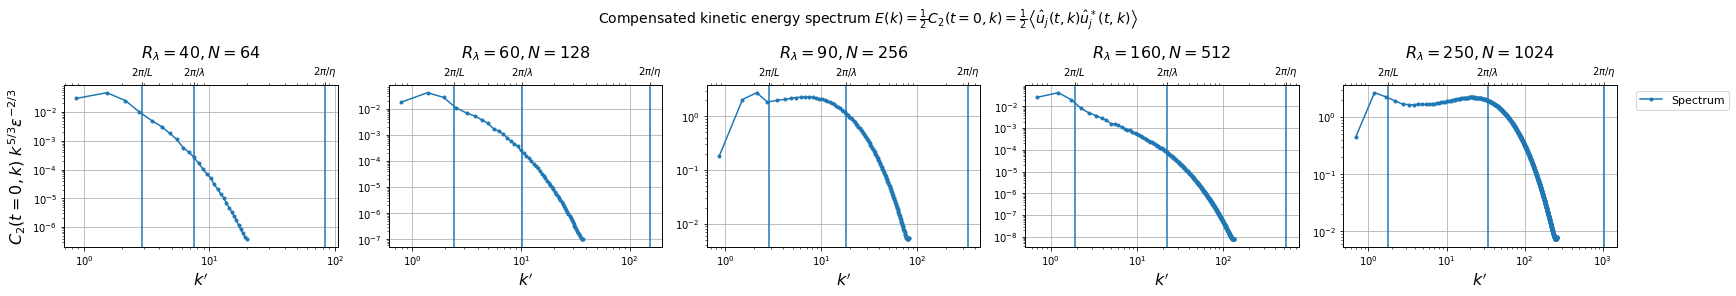

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Compensated kinetic energy spectrum $E(k) = \frac{1}{2} C_2(t=0, k) = \frac{1}{2} \left<\hat{u}_j(t,k) \hat{u}_j^* (t,k) \right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    simu['kinetic_energy'] = 0.5*simu['corr']['data'][0,::]
    simu['total_kinetic_energy'] = np.trapz(simu['kinetic_energy'], x=simu['k'])
    #simu['urms'] = np.sqrt(2.0/3.0*simu['total_kinetic_energy'])
    #simu['L'] = 2.0*np.pi*np.trapz(simu['k']**(-1)*simu['kinetic_energy'], x=simu['k'])/simu['total_kinetic_energy']
    #simu['t0'] = simu['L']/simu['urms']
    #simu['k_norm'] = 1/(2.0*np.pi/simu['L']) # integral scale as non-dimensionalisation factor
    simu['spatial_scales'] = np.array([simu['L'], simu['lambda'], simu['eta']])
    
    indices = slice(0,simu['ik_max'])
    ax[i].plot(simu['k'][indices]*simu['k_norm'], simu['kinetic_energy'][indices]*simu['k'][indices]**(5.0/3.0)*simu['dissip_rate']**(-2.0/3.0)*simu['spher_coef'][indices], '.-', label='Spectrum')
    
    ax[i].set(xscale='log',yscale='log',xlabel=r'$k^\prime$', title=simu['legend']); ax[i].grid()
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t=0,k) \ k^{5/3} \epsilon^{-2/3}$')

    # plot spatial scales
    vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
    for line in vertical_lines : ax[i].axvline(x=line)     
    ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

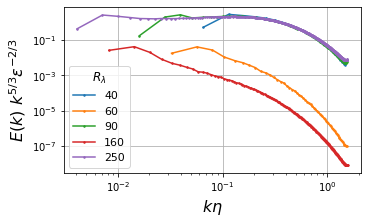

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3))
#fig.suptitle(r'Compensated kinetic energy spectrum $E(k) = \frac{1}{2} C_2(t=0, k) = \frac{1}{2} \left<\hat{u}_j(t,k) \hat{u}_j^* (t,k) \right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    simu['kinetic_energy'] = 0.5*simu['corr']['data'][0,::]
    indices = slice(0,simu['ik_max'])
    x = simu['k'][indices]*simu['eta']
    if (i==0) : ax.plot(x, simu['kinetic_energy'][indices]*4.0*np.pi*simu['k'][indices]**(11.0/3.0)*simu['dissip_rate']**(-2.0/3.0),\
            '.-', label=simu['Rl'], markersize=3.0)
    else :
        ax.plot(x, simu['kinetic_energy'][indices]*simu['k'][indices]**(5.0/3.0)*simu['dissip_rate']**(-2.0/3.0)*simu['spher_coef'][indices],\
            '.-', label=simu['Rl'], markersize=3.0)
    ax.set(xscale='log',yscale='log',xlabel=r'$k \eta$');
    ax.set(ylabel=r'$E(k) \ k^{5/3} \epsilon^{-2/3}$')
    ax.grid(True)
    # plot spatial scales
#     vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
#     for line in vertical_lines : ax.axvline(x=line)     
#     ax2 = ax.twiny(); ax2.set(xscale=ax.get_xscale(), yscale=ax.get_yscale(), xlim = ax.get_xlim())
#     ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    lgd = ax.legend(loc='best', title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Python/Images/Paper/spectrum.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

# Two-point spatio-temporal correlation function

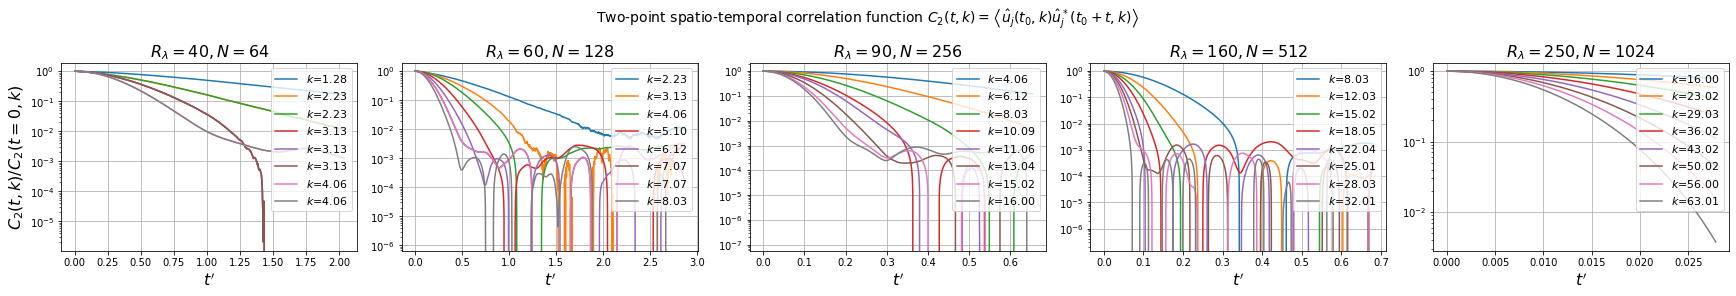

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['corr']
    for ik in simu['indices_of_k_to_plot4'] :
    #for ik in list(range(5))  :
        ax[i].plot(data_dict['time']/simu['t0'], data_dict['data'][:,ik] / data_dict['data'][0,ik], '-', label=r'$k$=%2.2f' % (simu['k'][ik]))
    ax[i].set(xscale='linear',yscale='log', xlabel=r'$t^\prime$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,0.3])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
    lgd = ax[i].legend(loc='upper right')

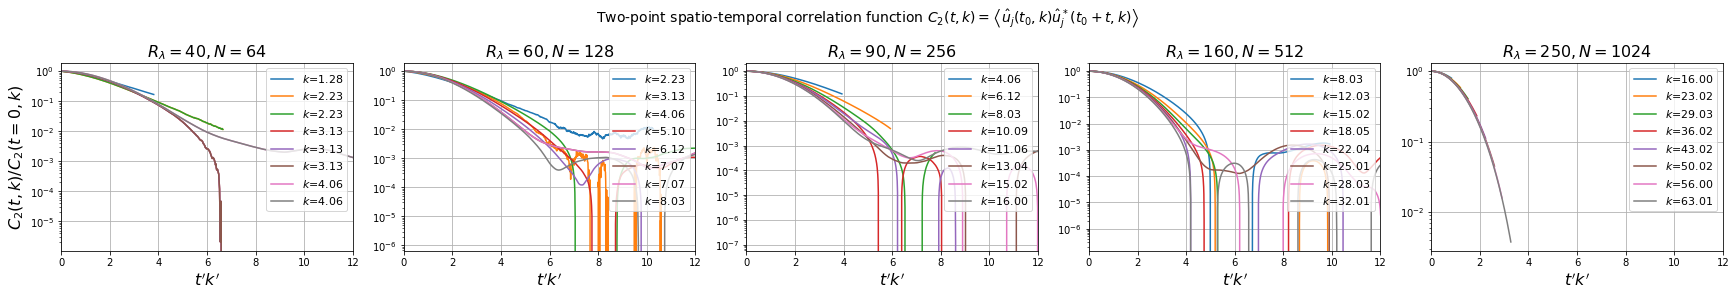

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['corr']
    for ik in simu['indices_of_k_to_plot4'] :
        ax[i].plot(data_dict['time']/simu['t0']*simu['k'][ik]*simu['L'], data_dict['data'][:,ik] / data_dict['data'][0,ik], '-', label=r'$k$=%2.2f' % (simu['k'][ik]))
    ax[i].set(xscale='linear',yscale='log', xlabel=r'$t^\prime k^\prime$', title=simu['legend']); ax[i].grid()
    ax[i].set(xlim=[0,12])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
    lgd = ax[i].legend(loc='upper right')

# Correlation fit

In [15]:
# Define the functions to fit

def linear_mult_gaussian(x, a, b, c):   
    return c*(1.0-b*x) * np.exp(-a*x**2.0) 
def linear_mult_gaussian_jacobian(x, a, b, c):   
    return np.transpose([-(x**2.0)*c*(1.0-b*x) * np.exp(-a * x**2.0), -c*x*np.exp(-a * x**2.0), (1.0-b*x) * np.exp(-a * x**2.0)])

def simple_gaussian(x, a, c):   
    return np.exp(-a * (x)**2.0 + c) 
def simple_gaussian_jacobian(x, a, c):   
    return np.transpose([-(x**2.0)*np.exp(-a * (x)**2.0 + c), np.exp(-a * (x)**2.0 + c)])

In [16]:
def try_to_fit(curve_function, xdata, ydata, sigma_ydata=None, jacobian_function=None) :
    number_of_params_of_optimization = len(signature(curve_function).parameters)-1
    coefficients = np.ndarray(shape=(number_of_params_of_optimization), dtype=float) 
    covariance_matrix = np.ndarray(shape=(number_of_params_of_optimization, number_of_params_of_optimization), dtype=float) 
    try :
        coefficients, covariance_matrix = curve_fit(curve_function, xdata, ydata, sigma=sigma_ydata, jac=jacobian_function, absolute_sigma=False)
    except :
        #print('[DEBUG] Failed optimization for ik = ', ik)
        coefficients.fill(np.nan); covariance_matrix.fill(np.nan)
    return [coefficients, covariance_matrix]

In [61]:
tk2_fit = 2.0
for simu in data_set : 
    simu['corr'].update({'fit_func': simple_gaussian, 'fit_jacobian' : simple_gaussian_jacobian})
    for dictionary in [simu['corr']] : 
        nb_of_params = len(signature(dictionary['fit_func']).parameters)-1
        dictionary.update({'fit_coef' : np.ndarray(shape=(len(simu['k']), nb_of_params), dtype=float)})
        dictionary.update({'fit_cov_matrix' : np.ndarray(shape=(len(simu['k']), nb_of_params, nb_of_params), dtype=float)})
    for ik in range(len(simu['k'])) :
        # fit the 2-point correlation function :
        dictionary = simu['corr']
        a = np.searchsorted(dictionary['time']/simu['t0']*simu['k'][ik]*simu['L'], 0.0)
        b = np.searchsorted(dictionary['time']/simu['t0']*simu['k'][ik]*simu['L'], tk2_fit)
        xdata = dictionary['time'][a:b]/simu['t0']
        normalization_coef = 1.0/dictionary['data'][0,ik]
        ydata = dictionary['data'][a:b,ik] * normalization_coef
        #error = np.sqrt(dictionary['data_var'][a:b, ik])*normalization_coef
        #dictionary['fit_coef'][ik, :], dictionary['fit_cov_matrix'][ik, :] = try_to_fit(dictionary['fit_func'], xdata, ydata, sigma_ydata=error, jacobian_function=dictionary['fit_jacobian'])
        dictionary['fit_coef'][ik, :], dictionary['fit_cov_matrix'][ik, :] = try_to_fit(dictionary['fit_func'], xdata, ydata, jacobian_function=dictionary['fit_jacobian'])
        #dictionary['perr'][ik] = np.sqrt(np.diag(dictionary['fit_cov_matrix'][ik, :]))

# Plot results

## Plots for C2

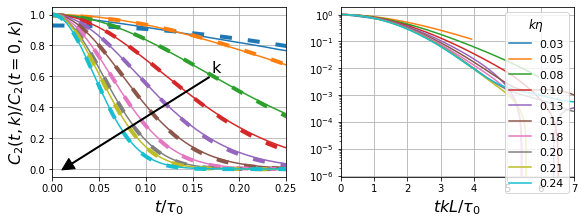

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2,constrained_layout=True,figsize=(8,3))
simu = data_set[2] # data set for Rl=160, N=512
#header = fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=18) 
data_dict=simu['corr']
x = data_dict['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot2'][::])) :
    ik = simu['indices_of_k_to_plot2'][i]
    ax[0].plot(x, data_dict['data'][:,ik] / data_dict['data'][0,ik], '-')
    ax[0].plot(x, data_dict['fit_func'](x, *data_dict['fit_coef'][ik,:]), ls=(0, (3, 4)), linewidth=4, color=colors[i])
    ax[1].plot(data_dict['time']*simu['k'][ik]*simu['urms'], data_dict['data'][:,ik] / data_dict['data'][0,ik], color=colors[i], label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
ax[0].set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0$', title=None); ax[0].grid()
ax[0].set(xlim=[0,0.25]); ax[0].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
ax[0].annotate('k', xy=(0.01, -0.005),  xycoords='data', xytext=(0.18, 0.7), textcoords='data', arrowprops=dict(facecolor='black', width=1), \
               size='16', horizontalalignment='right', verticalalignment='top')
ax[1].set(xscale='linear',yscale='log', xlabel=r'$t k L/\tau_0$', title=None); ax[1].grid()
ax[1].set(xlim=[0,7])
lgd = ax[1].legend(loc='best', title=r'$k\eta$', title_fontsize=12)
#plt.show()

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/tex_correlations/figures/2pcorr.pdf')
# pp.savefig()
# pp.close()

## Fitting params

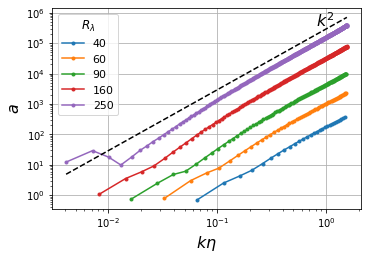

In [63]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
    ik1 = ik_min_decorr
    indices = slice(ik1,simu['ik_max'])
    #normalization = 1.0/(simu['L']**2.0)
    normalization = 1.0
    dictionary = simu['corr']
    ax.plot(simu['k'][indices]*simu['eta'], np.abs(dictionary['fit_coef'][indices,0])*normalization, '.-', label=simu['Rl'])
#ax.annotate(r'$R_\lambda$', xy=(1.8, 1e6),  xycoords='data', xytext=(1.8, 1e3), textcoords='data', arrowprops=dict(facecolor='black', width=2), size=16,horizontalalignment='center', verticalalignment='top')
ax.plot(simu['k'][indices]*simu['eta'], 0.3e1*(simu['k'][indices])**2.0, 'k--')
ax.annotate(r'$k^2$', xy=(0.8, 3.5e5), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$k\eta$',ylabel=r'$a$'); ax.grid()
#ax.set(xlim=[0.015,2.0])
#ax.set(xlim=[5,1e3]); ax.set(ylim=[1,10e5])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('Images/Correlations/2pcorrfitavskL2.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

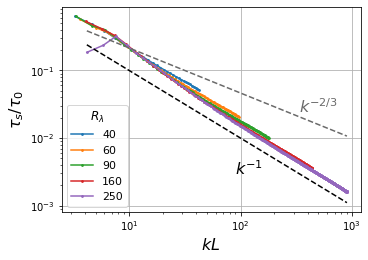

In [64]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
    ik1 = ik_min_decorr
    indices = slice(1,simu['ik_max'])
    #normalization = 1.0/(simu['L']**2.0)
    normalization = 1.0
    dictionary = simu['corr']
    x = simu['k'][indices]*simu['L']
    ax.plot(x, 1.0/np.sqrt(dictionary['fit_coef'][indices,0]), '.-', label=simu['Rl'], markersize=3.5)
ax.annotate(r'$k^{-1}$', xy=(120, 5e-3),  xycoords='data', size=16, horizontalalignment='center', verticalalignment='top')
ax.annotate(r'$k^{-2/3}$', xy=(500, 4e-2),  xycoords='data', color='dimgray', size=16, horizontalalignment='center', verticalalignment='top')
ax.plot(x, (x)**(-1), 'k--')
ax.plot(x, (x)**(-2.0/3.0), '--', color='dimgray')
#ax.annotate(r'$k^2$', xy=(0.8, 3.5e5), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$kL$',ylabel=r'$\tau_s/\tau_0$'); ax.grid()
#ax.set(xlim=[0.015,2.0])
#ax.set(xlim=[5,1e3]); ax.set(ylim=[1,10e5])
lgd = ax.legend(loc='lower left',title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Python/Images/Paper/tauSvsKL.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


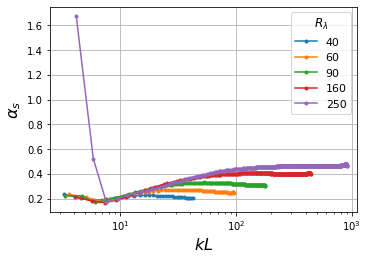

In [65]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for simu in data_set[:] :
    ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
    ik1 = 1
    indices = slice(ik1,simu['ik_max'])
    normalization = 1.0/((simu['k'][indices]*simu['L'])**2.0)
    #normalization = 1.0
    dictionary = simu['corr']
    #ax.plot(simu['k'][indices]*simu['L'], np.abs(dictionary['fit_coef'][indices,0])*normalization, '.-', label=simu['Rl'], color=colors[i])
    ax.plot(simu['k'][indices]*simu['L'], dictionary['fit_coef'][indices,0]*normalization, '.-', label=simu['Rl'])
    #ax.plot(simu['k'][indices]*simu['L'], dictionary['exp_width'][indices,0], '.-', label=simu['Rl'], color=colors[i])
#ax.annotate(r'$R_\lambda$', xy=(1.8, 1e6),  xycoords='data', xytext=(1.8, 1e3), textcoords='data', arrowprops=dict(facecolor='black', width=2), size=16,horizontalalignment='center', verticalalignment='top')
#ax.plot(simu['k'][indices]*simu['eta'], 1e1*(simu['k'][indices])**2.0, 'k--', label=r'$k^2$')
#ax.annotate(r'$k^2$', xy=(1.15, 1.6e6), xycoords='data', size='16')
ax.set(xscale='log', yscale='linear', xlabel=r'$kL$',ylabel=r'$\alpha_s$'); ax.grid()
ax.set(xlim=[0,1100])
lgd = ax.legend(loc='best', title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Python/Images/Paper/2pcorrfitak2vskL.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

# Deviation from Gaussian

In [66]:
for simu in data_set : 
    simu['indices_of_k_to_plot2'] = np.array(np.searchsorted(simu['k']*simu['L'], np.linspace(3, 28, 10)),dtype=int)
    simu['indices_of_k_to_plot4'] = np.array(np.searchsorted(simu['k']*simu['eta'], np.linspace(0.08, 1.0, 8)),dtype=int)

Cut-off the tails of the corr. function where the normalized amplitudes is below the threshold :

In [67]:
threshold = 5e-3
for i,simu in enumerate(data_set) : 
    simu['it_cut-off'] = np.zeros_like(simu['k'], dtype=int)
    for ik, k in enumerate(simu['k']) :
        tail = np.argwhere(simu['corr']['data'][:,ik]/simu['corr']['data'][0,ik]<0)
        if (len(tail) > 0) :
            max_tail = np.max(simu['corr']['data'][tail[0][0]:,ik])
            small_amplitudes = np.argwhere(simu['corr']['data'][:,ik]/simu['corr']['data'][0,ik]<np.max([max_tail, threshold]))
            if (len(small_amplitudes) > 0) :
                simu['it_cut-off'][ik] = small_amplitudes[0,0]
        else :
            small_amplitudes = np.argwhere(simu['corr']['data'][:,ik]/simu['corr']['data'][0,ik]<threshold)
            if (len(small_amplitudes) > 0) :
                simu['it_cut-off'][ik] = small_amplitudes[0,0]
            else :
                simu['it_cut-off'][ik] = len(simu['corr']['time']) - 1

Find the beginning of the deviation from the Gaussian (deviation larger than threshold):

In [68]:
threshold_gaussian_deviation = 1e-1
for i,simu in enumerate(data_set) : 
    simu['it_deviation'] = np.zeros_like(simu['k'], dtype=int)
    for ik, k in enumerate(simu['k']) :
        correlations = simu['corr']['data'][:,ik]/simu['corr']['data'][0,ik]
        x = simu['corr']['time']/simu['t0']
        gaussian = simu['corr']['fit_func'](x, *simu['corr']['fit_coef'][ik,:])
        large_deviations = np.argwhere((np.abs(correlations - gaussian)/gaussian)>threshold_gaussian_deviation)
        #large_deviations = np.argwhere(((correlations - gaussian)/gaussian)>threshold_gaussian_deviation)
        if (len(large_deviations) > 0) :
            simu['it_deviation'][ik] = large_deviations[0,0]
        else :
            simu['it_deviation'][ik] = len(simu['corr']['time']) - 1

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in true_divide
  


/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in true_divide
  
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


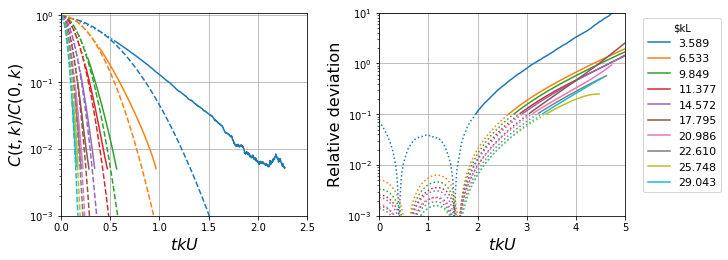

In [69]:
simu = data_set[1]

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,3.5))
fig.suptitle=('Deviation from Gaussian')
for i,ik in enumerate(simu['indices_of_k_to_plot2'][:]) :
    scaling = simu['k'][ik]*simu['L']
    x = simu['corr']['time']/simu['t0']
    correlations = simu['corr']['data'][:,ik]/simu['corr']['data'][0,ik]
    gaussian = simu['corr']['fit_func'](x, *simu['corr']['fit_coef'][ik,:])
    
    time_sl = np.s_[0:simu['it_deviation'][ik]]
    ax[0].plot(x[time_sl], correlations[time_sl], ':', color=colors[i], label='%2.3f' % (simu['k'][ik]*simu['eta']))
    ax[0].plot(x, gaussian, '--', color=colors[i], label='%2.1f' % simu['k'][ik])
    ax[1].plot(x[time_sl]*scaling, (np.abs(correlations - gaussian)/gaussian)[time_sl], ':', color=colors[i])
    
    time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
    ax[1].plot(x[time_sl]*scaling, (np.abs(correlations - gaussian)/gaussian)[time_sl], '-', color=colors[i], label='%2.3f' % (simu['k'][ik]*simu['L']))
    ax[0].plot(x[time_sl], correlations[time_sl], '-', color=colors[i])

ax[0].set(xscale='linear',yscale='log', xlabel=r'$t k U$', ylabel=r'$C(t,k)/C(0,k)$'); ax[0].grid()
ax[1].set(xscale='linear',yscale='log', xlabel=r'$t k U$', ylabel=r'Relative deviation'); ax[1].grid()

ax[0].set(xlim=[0,2.5])
ax[0].set(ylim=[10e-4,1.1])

x_max = 5.0
ax[1].set(xlim=[0,x_max])
ax[1].set(ylim=[10e-4,10])

leg = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$kL')

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

In [70]:
for i,simu in enumerate(data_set) : 
    data_dict = simu['corr']
    data_dict['large_time_fit'] = np.full([len(simu['k']),3], np.nan)
    for ik, k in enumerate(simu['k']) :
        time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
        x = data_dict['time'][time_sl]/simu['t0']
        y = np.log(data_dict['data'][time_sl,ik])
        if (len(y) > 10) :
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            data_dict['large_time_fit'][ik] = [slope, intercept, std_err]

No handles with labels found to put in legend.


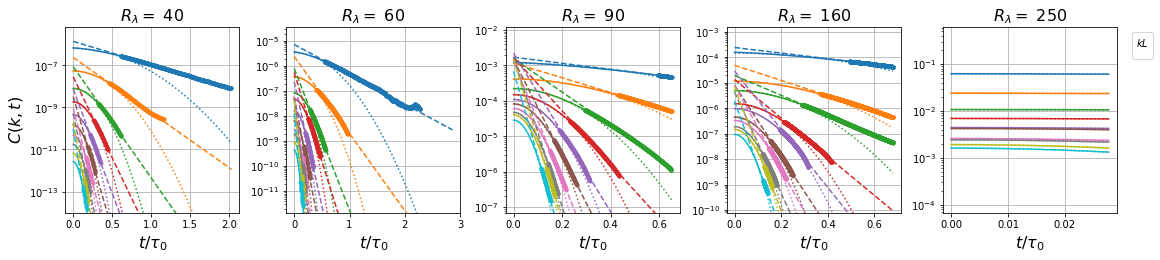

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set[:]), constrained_layout=True,figsize=(16,3.5))

for i,simu in enumerate(data_set[:]) : 
    k_set = simu['indices_of_k_to_plot2'][:]
    for iik,ik in enumerate(k_set) :
        horizontal_scaling = simu['k'][ik]*simu['L']
        horizontal_scaling = 1.0
        time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
        x = simu['corr']['time']/simu['t0']
        correlations = simu['corr']['data'][:,ik]
        gaussian = simu['corr']['fit_func'](x, *simu['corr']['fit_coef'][ik,:])*simu['corr']['data'][0,ik]
        
        if (len(x[time_sl]) > 0) :
            ax[i].plot(x[time_sl]*horizontal_scaling, correlations[time_sl], '.-', color=colors[iik], label='%2.3f' % (simu['k'][ik]*simu['L']))
        #ax.plot(x*horizontal_scaling, gaussian, ':', color=colors[i])
        ax[i].plot(x*horizontal_scaling, np.exp(simu['corr']['large_time_fit'][ik][0]*x + simu['corr']['large_time_fit'][ik][1]), '--', color=colors[iik])

        time_sl = np.s_[0:simu['it_deviation'][ik]]
        ax[i].plot(x[time_sl]*horizontal_scaling, correlations[time_sl], '-', color=colors[iik])
        ax[i].plot(x*horizontal_scaling, gaussian, ':', color=colors[iik])
        
    ax[i].set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', title=r'$R_\lambda=$ %2.0i'%simu['Rl']); ax[i].grid()

    #x_max = simu['corr']['time'][:simu['it_cut-off'][k_set[4]]+50][-1]/simu['t0']*simu['k'][k_set[4]]*simu['L']
    x_max = simu['corr']['time'][:simu['it_cut-off'][k_set[0]]+50][-1]/simu['t0']
    #ax[i].set(xlim=[0,x_max])
    if (len(x[time_sl]) > 0) :
        ax[i].set(ylim=[0.05*simu['corr']['data'][time_sl,k_set[-1]][-1],10*simu['corr']['data'][time_sl,k_set[0]][0]])

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$kL$')
ax[0].set(ylabel=r'$C(k,t)$')
#lgd = ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k\eta$')
# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

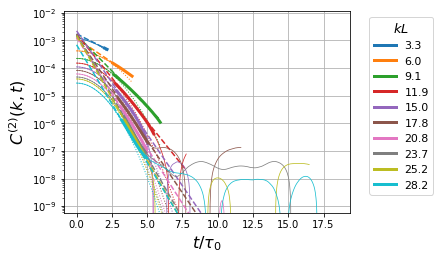

In [72]:
simu = data_set[2]

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,3.5))

k_set = simu['indices_of_k_to_plot2'][:]
for i,ik in enumerate(k_set) :
    horizontal_scaling = simu['k'][ik]*simu['L']
    #horizontal_scaling = 1.0
    time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]+30]
    x = simu['corr']['time']/simu['t0']
    correlations = simu['corr']['data'][:,ik]
    gaussian = simu['corr']['fit_func'](x, *simu['corr']['fit_coef'][ik,:])*simu['corr']['data'][0,ik]
    
    ax.plot(x[time_sl]*horizontal_scaling, correlations[time_sl], '-', color=colors[i], label='%2.1f' % (simu['k'][ik]*simu['L']), lw=3)
    ax.plot(x*horizontal_scaling, correlations[:], color=colors[i], lw=0.75)
    ax.plot(x*horizontal_scaling, np.exp(simu['corr']['large_time_fit'][ik][0]*x + simu['corr']['large_time_fit'][ik][1]), '--', color=colors[i])
    ax.plot(x*horizontal_scaling, gaussian, ':', color=colors[i], lw=1)

ax.set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', ylabel=r'$C^{(2)}(k,t)$'); ax.grid()

#x_max = simu['corr']['time'][-1]/simu['t0']
#ax.set(xlim=[0,x_max])
ax.set(ylim=[0.01*simu['corr']['data'][time_sl,k_set[-1]][-1],10*simu['corr']['data'][time_sl,k_set[0]][0]])

leg = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$kL$', title_fontsize=13)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/gaussianDeviation.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

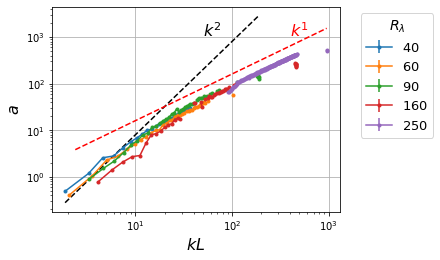

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,3.5))

for i,simu in enumerate(data_set[:]) : 
    xscaling = simu['L']
    vertical_scaling = 1.0/simu['L']**2
    ax.errorbar(simu['k']*xscaling, -simu['corr']['large_time_fit'][:,0]*vertical_scaling, yerr=simu['corr']['large_time_fit'][:,2]*vertical_scaling, color=colors[i], ls='-', marker='.', label=r'$%2.0i$' % simu['Rl'])
ax.plot(data_set[2]['k']*data_set[0]['L'], 8e-2*(data_set[2]['k']*data_set[0]['L'])**2, '--', color='k')
ax.plot(simu['k']*xscaling, 3e0*simu['k'], '--', color='r')
ax.set(xlabel=r'$kL$', ylabel=r'$a$', yscale='log', xscale='log'); ax.grid()
ax.annotate(r'$k^{2}$', xy=(50, 1000), xycoords='data', size='16')
ax.annotate(r'$k^{1}$', xy=(400, 1000), xycoords='data', size='16',color='r')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13, title=r'$R_\lambda$',title_fontsize=14)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/large_time_fit.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

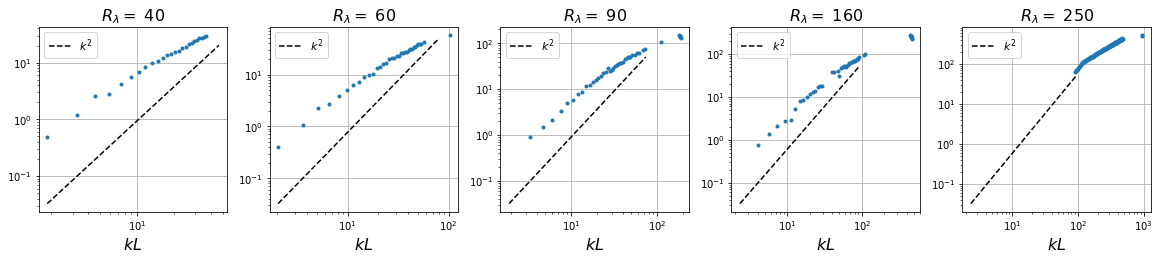

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(16,3.5))

for i,simu in enumerate(data_set[:]) : 
    xscaling = simu['L']
    vertical_scaling = 1.0/simu['L']**2
    ax[i].errorbar(simu['k']*xscaling, -simu['corr']['large_time_fit'][:,0]*vertical_scaling, yerr=simu['corr']['large_time_fit'][:,2]*vertical_scaling, \
                   ls='', marker='.')
    end_fit = np.searchsorted(simu['k']*simu['L'], 15)
    #slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(simu['k'][1:end_fit]*xscaling), np.log(-simu['corr']['large_time_fit'][1:end_fit,0]*vertical_scaling))
    #print(slope)
    #ax[i].plot(simu['k']*xscaling, 1e-1*simu['k']**2, '--', color='k', label=r'$k^{2}$')
    #ax[i].plot(simu['k'][1:]*xscaling, np.exp(slope*np.log(simu['k'][1:]*xscaling) + intercept), '--', color='r', label=r'$k^{1}$')
    ax[i].plot(simu['k'][:50]*xscaling, 2e-2*simu['k'][:50]**2, '--', color='k', label=r'$k^{2}$')
    ax[i].set(xlabel=r'$kL$', title=r'$R_\lambda=$ %2.0i'%simu['Rl'], yscale='log', xscale='log'); ax[i].grid()
    ax[i].legend()
#     ax[i].set(xlim=[0.03,1.1])
#    ax[i].set(ylim=[0,-simu['corr']['large_time_fit'][-1,0]*vertical_scaling])

plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


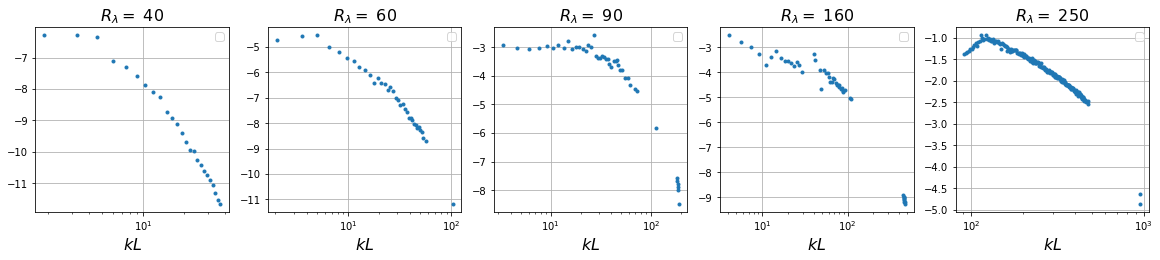

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(16,3.5))

for i,simu in enumerate(data_set[:]) : 
    xscaling = simu['L']
    vertical_scaling = 1.0/simu['L']**2
    ax[i].plot(simu['k']*xscaling, simu['corr']['large_time_fit'][:,1]*vertical_scaling, ls='', marker='.')
    #ax[i].plot(simu['k']*xscaling, 1e-1*simu['k']**0.5, '--', color='k', label=r'$k^{2}$')
    #ax[i].plot(simu['k'][1:]*xscaling, np.exp(slope*np.log(simu['k'][1:]*xscaling) + intercept), '--', color='r', label=r'$k^{1}$')
    ax[i].set(xlabel=r'$kL$', title=r'$R_\lambda=$ %2.0i'%simu['Rl'], yscale='linear', xscale='log'); ax[i].grid()
    ax[i].legend()
#     ax[i].set(xlim=[0.03,1.1])
#    ax[i].set(ylim=[0,-simu['corr']['large_time_fit'][-1,0]*vertical_scaling])

plt.show()

# Crossover through derivative

In [76]:
# compute time derivatives of the corr function
for simu in data_set : 
    simu['deriv1'] = np.ndarray(shape=(len(simu['k']), len(simu['corr']['time'])), dtype=float)
    for ik in range(len(simu['k'])) :
        sl = np.s_[0:simu['it_cut-off'][ik]]
        data = np.log(simu['corr']['data'][:,ik])
        simu['deriv1'][ik,:] = np.gradient(data, simu['corr']['time']/simu['t0'], edge_order=1)

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


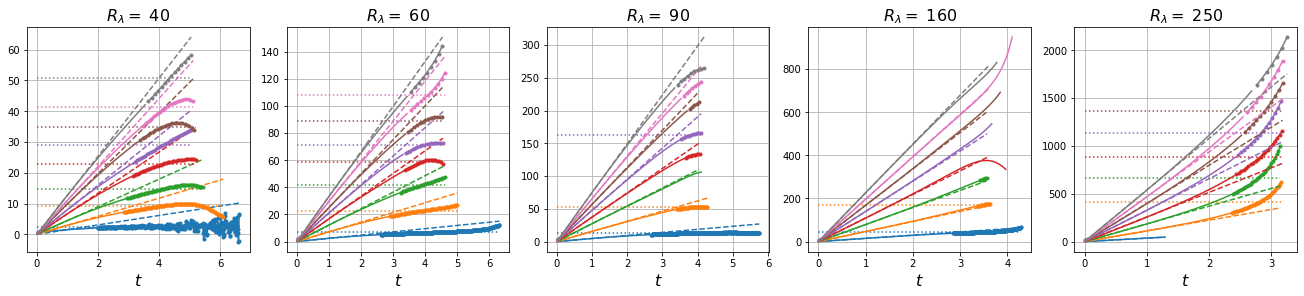

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(18,4))

for i,simu in enumerate(data_set[:]) : 
        k_set = simu['indices_of_k_to_plot4'][:]
        for iik,ik in enumerate(k_set) :
            xscaling = simu['k'][ik]*simu['L']
            time_sl0 = np.s_[:simu['it_deviation'][ik]]
            time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
            time_sl2 = np.s_[:simu['it_cut-off'][ik]]
            x = simu['corr']['time']/simu['t0']*xscaling
            ax[i].plot(x[time_sl0], -simu['deriv1'][ik,time_sl0], '-', color=colors[iik])
            ax[i].plot(x[time_sl], -simu['deriv1'][ik,time_sl], '.-', color=colors[iik])
            ax[i].plot(x[time_sl2], 2.0*simu['corr']['fit_coef'][ik,0]*simu['corr']['time'][time_sl2]/simu['t0'], '--', color=colors[iik])
            ax[i].plot(x[time_sl2], -np.full_like(x[time_sl2], simu['corr']['large_time_fit'][ik,0]), ':', color=colors[iik])
        ax[i].set(xlabel=r'$t$', title=r'$R_\lambda=$ %2.0i'%simu['Rl'], yscale='linear', xscale='linear'); ax[i].grid()
#    ax[i].legend()
#     ax[i].set(xlim=[0.03,1.1])
#    ax[i].set(ylim=[0,-simu['corr']['large_time_fit'][-1,0]*vertical_scaling])

plt.show()

# Oscillating fit

In [78]:
# # Define the functions to fit
# def exp_argument(t, W1, W2) : 
#     return -(-1+np.cos(W1*t)+W1*t*special.sici(W1*t)[0])/W1 + (-1+np.cos(W2*t)+W2*t*special.sici(W2*t)[0])/W2

# def oscillating(t, A, B, C, W1, W2):   
#     return np.exp(A*exp_argument(t,W1,W2) + B) + C
# def oscillating_jacobian(t, A, B, C, W1, W2):   
#     return np.transpose([ (oscillating(t, A,B, C, W1, W2) - C)*exp_argument(t,W1,W2), \
#                          oscillating(t, A,B, C, W1, W2) - C, \
#                          np.full_like(t, 1.0), \
#                         A*(oscillating(t, A,B,C, W1, W2) - C)*(-(-t*np.sin(t*W1)+t*t*W1*special.sinc(t*W1))/W1 + (-1+np.cos(t*W1)+t*W1*special.sici(W1*t)[0])/W1**2), \
#                         A*(oscillating(t, A,B,C, W1, W2) - C)*(-(-t*np.sin(t*W2)+t*t*W2*special.sinc(t*W2))/W2 + (-1+np.cos(t*W2)+t*W2*special.sici(W2*t)[0])/W2**2)])

In [79]:
# Define the functions to fit
def exp_argument(t, W1) : 
    return -(-1+np.cos(W1*t)+W1*t*special.sici(W1*t)[0])/W1 + 0.5*np.pi*t

def oscillating(t, A, B, C, W1):   
    return np.exp(A*exp_argument(t,W1) + B) + C
def oscillating_jacobian(t, A, B, C, W1):   
    return np.transpose([ (oscillating(t, A,B, C, W1) - C)*exp_argument(t,W1), \
                         oscillating(t, A,B, C, W1) - C, \
                         np.full_like(t, 1.0), \
                         A*(oscillating(t, A,B,C, W1) - C)*(-(-t*np.sin(t*W1)+t*t*W1*special.sinc(t*W1)+t*special.sici(W1*t)[0])/W1 + (-1+np.cos(t*W1)+t*W1*special.sici(W1*t)[0])/W1**2)])

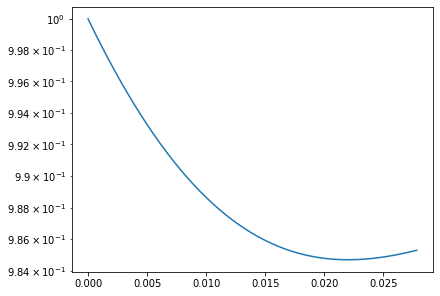

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,4))

ax.semilogy(simu['corr']['time']/simu['t0'], oscillating(simu['corr']['time']/simu['t0'], -1, 0, 0, 100*2*np.pi/simu['t0']))

plt.show()

In [81]:
for simu in data_set : 
    simu['corr'].update({'fit_func2': oscillating, 'fit_jacobian2' : oscillating_jacobian})
    dictionary=simu['corr']
    nb_of_params = len(signature(dictionary['fit_func2']).parameters)-1
    dictionary.update({'fit_coef2' : np.ndarray(shape=(len(simu['k']), nb_of_params), dtype=float)})
    dictionary.update({'fit_cov_matrix2' : np.ndarray(shape=(len(simu['k']), nb_of_params, nb_of_params), dtype=float)})
    for ik in range(len(simu['k'])) :
        a = simu['it_deviation'][ik]
        b = simu['it_cut-off'][ik]
        if ((b-a)>10) : 
            xdata = dictionary['time'][a:b]/simu['t0']
            normalization_coef = 1.0/dictionary['data'][0,ik]
            ydata = dictionary['data'][a:b,ik] * normalization_coef
            #dictionary['fit_coef2'][ik, :], dictionary['fit_cov_matrix2'][ik, :] = try_to_fit(dictionary['fit_func2'], xdata, ydata, jacobian_function=dictionary['fit_jacobian2'])
            dictionary['fit_coef2'][ik, :], dictionary['fit_cov_matrix2'][ik, :] = curve_fit(dictionary['fit_func2'], xdata, ydata, jac=dictionary['fit_jacobian2'], absolute_sigma=False)

/home/gorbunov8a/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 500.

In [ ]:
simu = data_set[0]

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,3.5))
for i,ik in enumerate(simu['indices_of_k_to_plot2'][:]) :
    scaling = simu['k'][ik]*simu['L']
    x = simu['corr']['time']/simu['t0']
    correlations = simu['corr']['data'][:,ik]/simu['corr']['data'][0,ik]
    fit = simu['corr']['fit_func2'](x, *simu['corr']['fit_coef2'][ik,:])
    
    time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
    time_sl = np.s_[simu['it_deviation'][ik]:]
    ax.plot(x[time_sl], correlations[time_sl], '.', color=colors[i], label='%2.3f' % (simu['k'][ik]*simu['L']))
    ax.plot(x, fit, '--', color=colors[i])
    
#     time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
#     ax.plot(x[time_sl], correlations[time_sl], '-', color=colors[i])

ax.set(xscale='linear',yscale='log', xlabel=r'$t k U$', ylabel=r'$C(t,k)/C(0,k)$'); ax.grid()

ax.set(xlim=[0,2.0])
ax.set(ylim=[10e-5,1.1])

leg = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'kL')

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(16,3.5))

for i,simu in enumerate(data_set[:]) : 
    xscaling = simu['L']
    vertical_scaling = 1.0/simu['L']**2
    ax[i].errorbar(simu['k']*xscaling, -simu['corr']['fit_coef2'][:,0]*vertical_scaling, yerr=simu['corr']['large_time_fit'][:,2]*vertical_scaling, \
                   ls='', marker='.')
#     end_fit = np.searchsorted(simu['k']*simu['L'], 15)
#     slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(simu['k'][1:end_fit]*xscaling), np.log(-simu['corr']['large_time_fit'][1:end_fit,0]*vertical_scaling))
#     print(slope)
    ax[i].plot(simu['k']*xscaling, 1e-1*simu['k']**2, '--', color='k', label=r'$k^{2}$')
#    ax[i].plot(simu['k'][1:]*xscaling, np.exp(slope*np.log(simu['k'][1:]*xscaling) + intercept), '--', color='r', label=r'$k^{1}$')
    ax[i].set(xlabel=r'$kL$', title=r'$R_\lambda=$ %2.0i'%simu['Rl'], yscale='log', xscale='log'); ax[i].grid()
    ax[i].legend()
#     ax[i].set(xlim=[0.03,1.1])
#    ax[i].set(ylim=[0,-simu['corr']['fit_coef2'][-1,0]*vertical_scaling])

plt.show()